In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency


plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('preprocessed_fire_data_clean.csv')

In [3]:
print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dataset: 200,000 rows × 20 columns


In [4]:
df.head()

,latitude,longitude,scan,track,satellite,instrument,confidence,version,daynight,year,month,day_of_year,week_of_year,season,is_fire_season,is_daytime,acq_hour,is_afternoon,region,severity_class
0,-12.07912,134.55260,0.45,0.47,N,VIIRS,75,2,D,2023,6,180,26,Winter,0,1,5,0,North,1
1,-15.75430,129.01073,0.37,0.58,N,VIIRS,75,2,D,2021,11,320,46,Spring,1,1,4,0,North,0
2,-21.43215,117.24640,0.50,0.41,N,VIIRS,75,2,D,2024,6,158,23,Winter,0,1,6,0,Central,2
3,-17.89678,130.74759,0.49,0.65,N,VIIRS,75,2,D,2024,4,111,16,Autumn,0,1,4,0,North,0
4,-24.16475,151.12544,0.37,0.58,N,VIIRS,75,2,D,2023,10,294,42,Spring,0,1,4,0,Central,0


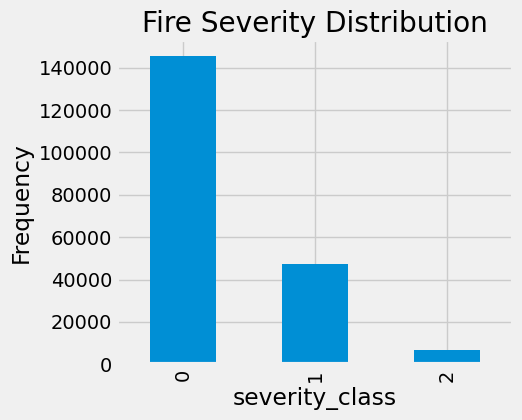

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['severity_class'].value_counts().plot(kind='bar')
plt.title('Fire Severity Distribution')
plt.ylabel('Frequency')
plt.show()

In [6]:
def categorical_categorical_analysis_simple(df: pd.DataFrame, cat1: str, cat2: str) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    cross_tab = pd.crosstab(df[cat1], df[cat2])
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax[0])
    ax[0].set_title(f'{cat1} vs {cat2}\nFrequency Heatmap')
    
    # 2. Stacked percentage bar plot
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    cross_tab_pct.plot(kind='bar', stacked=True, ax=ax[1], colormap='Set3')
    ax[1].set_title(f'{cat1} vs {cat2}\nPercentage Distribution')
    ax[1].set_ylabel('Percentage (%)')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [7]:
#Multivariate Analysis:
def multivariate_analysis(df,cat_col1,cat_col2,num_col=None):
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))

    # Violin Plot and barplot for the categorical features:
    sns.violinplot(x=df[cat_col1],y=df[num_col],hue=df[cat_col2],color='purple',ax=ax[0])
    sns.barplot(x=df[cat_col1],y=df[num_col],hue=df[cat_col2],color='red',linewidth=0.7,ax=ax[1])

    ax[0].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()

In [8]:
# Function to check normality:
def normality_check(df,feature,alpha=0.05):
    
    stat,p_value=stats.jarque_bera(df[feature])
    print(f"The p_value is:{p_value}")

    if p_value<=alpha:
        print("Reject Null Hypothesis. The data is not normally distributed")
    else:
        print("Fail to reject Null Hypothesis. The data is normally distributed")

# ANOVA:
def anova_test(df:pd.DataFrame, num_col, cat_col,alpha=0.05):
    data=df.loc[:,[num_col,cat_col]].dropna()

    cat_group=df.groupby(cat_col)
    groups=[group[num_col].values for _,group in cat_group]
    f_stat,p_value=stats.f_oneway(*groups)
    print(p_value)

    if p_value<=alpha:
        print(f"Reject null hypothesis. There is a significant relationship between {num_col} and {cat_col}")
    else:
        print(f"Fail to reject null hypothesis. There is no significant relationship between {num_col} and {cat_col}")

#Chi-Sqaure test:
def chiq_square(df:pd.DataFrame,cat_col1,cat_col2,alpha=0.05):
    data=df.loc[:,[cat_col1,cat_col2]]
    contingency_table=pd.crosstab(data[cat_col1],data[cat_col2])
    test_stats,p_value,_,_=stats.chi2_contingency(contingency_table)
    print(p_value)
    if p_value<alpha:
        print(f"Reject Null Hypothesis. There is significant associaion between {cat_col1} and {cat_col2}")
    else:
        print(f"Fail to reject Null Hypothesis. There is no significant associaion between {cat_col1} and {cat_col2}")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitude        200000 non-null  float64
 1   longitude       200000 non-null  float64
 2   scan            200000 non-null  float64
 3   track           200000 non-null  float64
 4   satellite       200000 non-null  object 
 5   instrument      200000 non-null  object 
 6   confidence      200000 non-null  int64  
 7   version         200000 non-null  int64  
 8   daynight        200000 non-null  object 
 9   year            200000 non-null  int64  
 10  month           200000 non-null  int64  
 11  day_of_year     200000 non-null  int64  
 12  week_of_year    200000 non-null  int64  
 13  season          200000 non-null  object 
 14  is_fire_season  200000 non-null  int64  
 15  is_daytime      200000 non-null  int64  
 16  acq_hour        200000 non-null  int64  
 17  is_afterno

BIVARIATE ANALYSIS (NUMERICAL VS CATEGORICAL)
Relationship: region vs severity_class


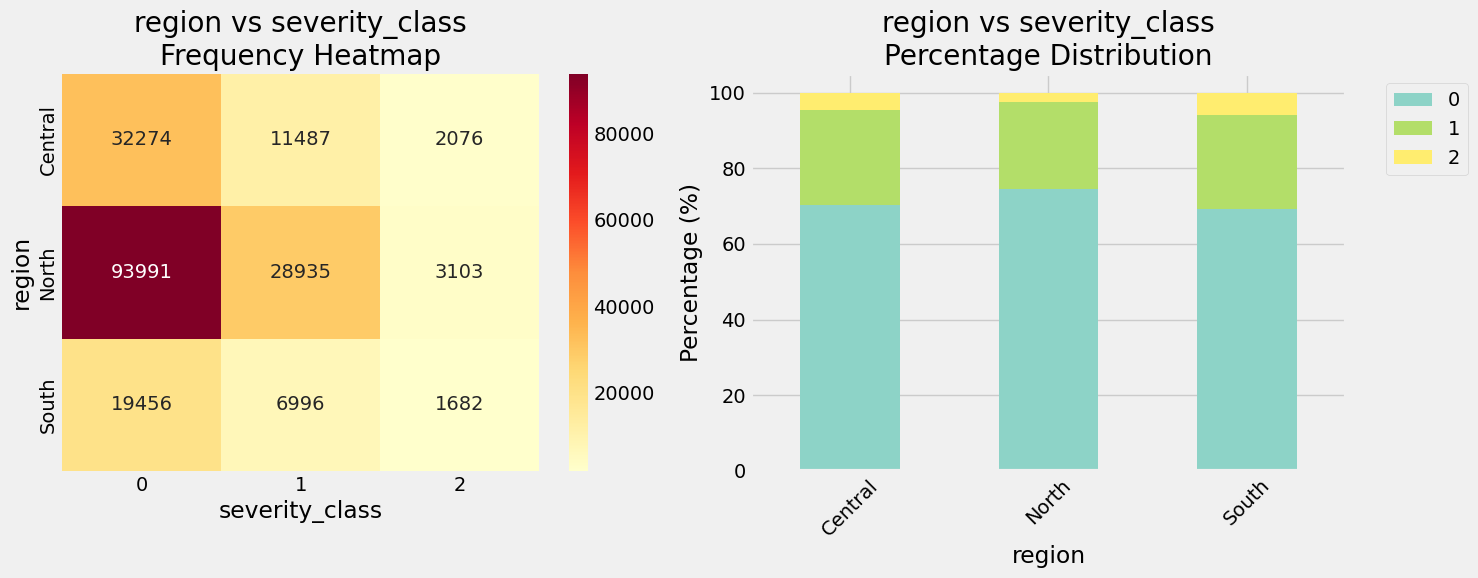

Relationship: season vs severity_class


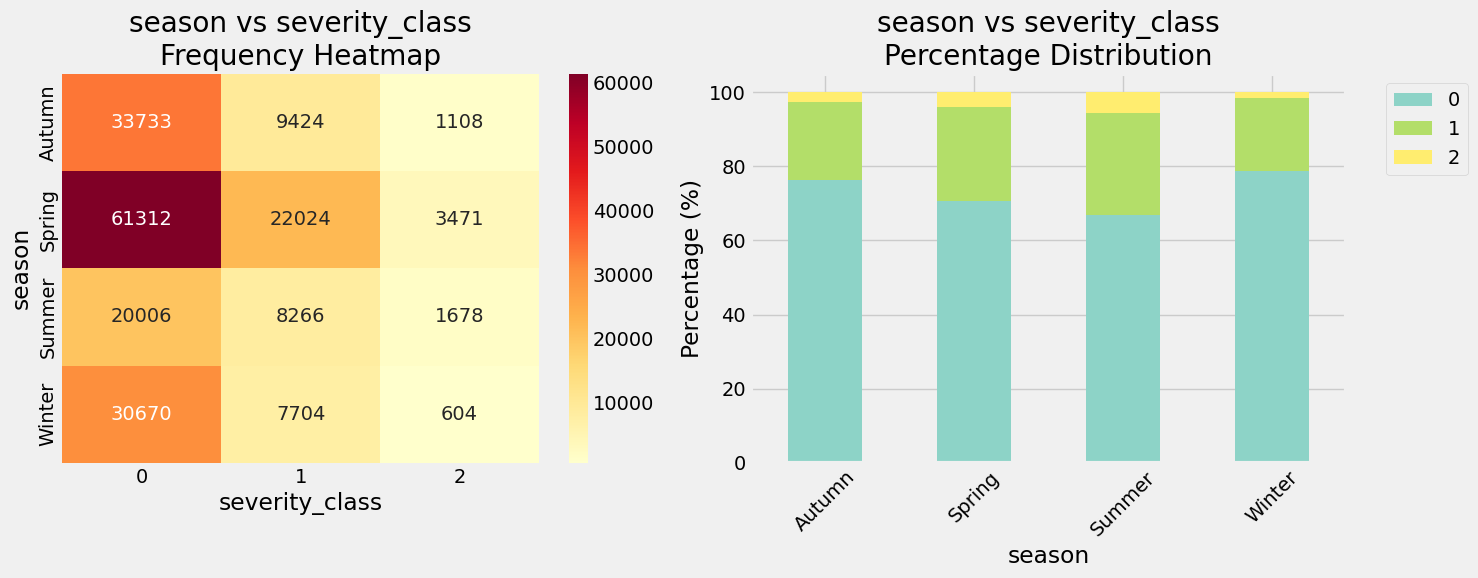

Relationship: daynight vs severity_class


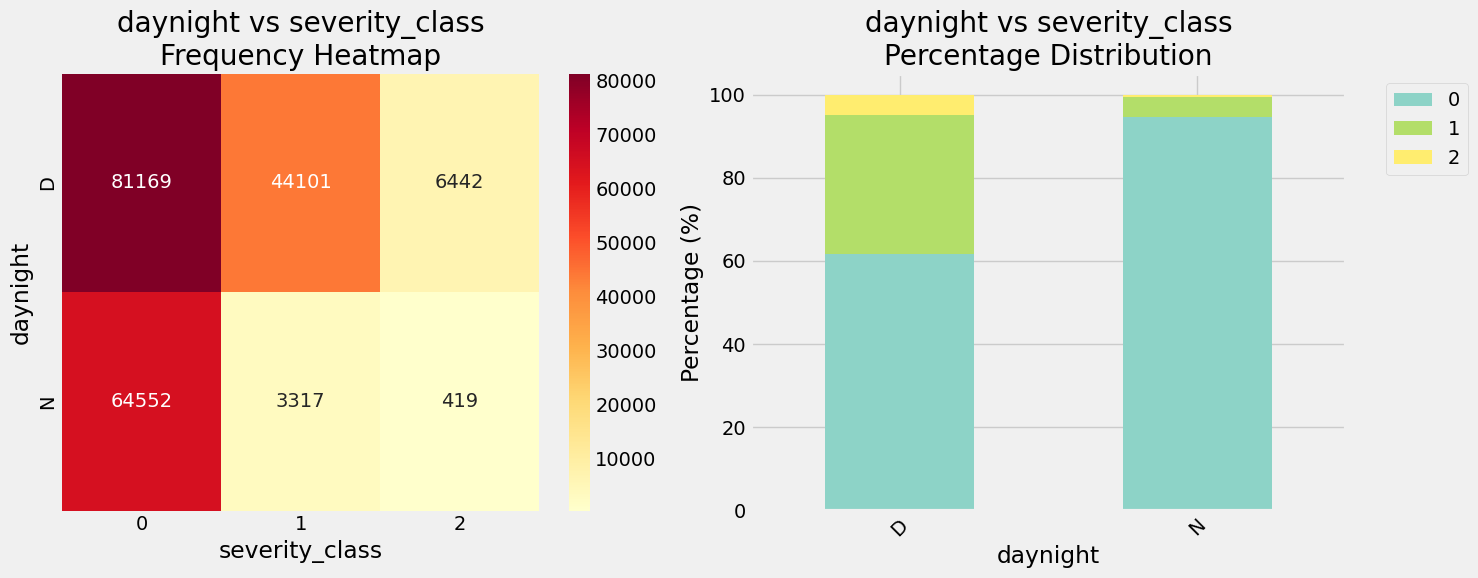

Relationship: is_fire_season vs severity_class


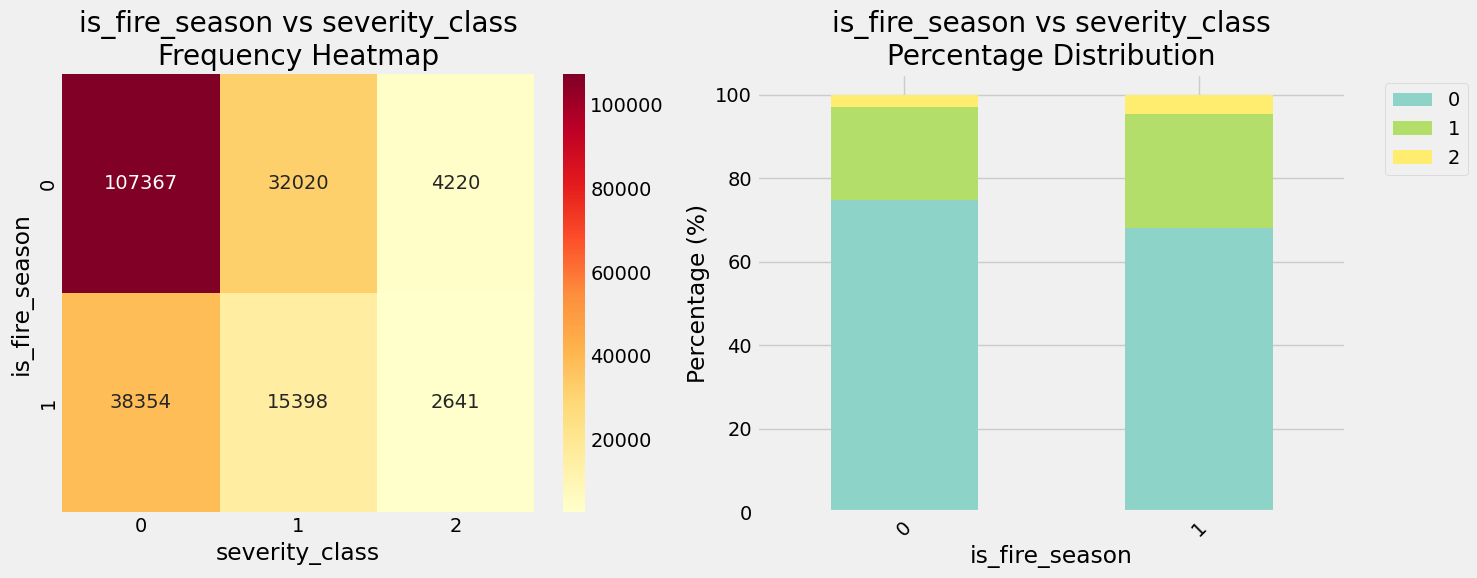

In [10]:
print("BIVARIATE ANALYSIS (NUMERICAL VS CATEGORICAL)")

relationships = [
    ('region', 'severity_class'),
    ('season', 'severity_class'),
    ('daynight', 'severity_class'),
    ('is_fire_season', 'severity_class'),
]

for cat_col1, cat_col2 in relationships:
    print(f"Relationship: {cat_col1} vs {cat_col2}")
    categorical_categorical_analysis_simple(df, cat_col1, cat_col2)

In [11]:
print("STATISTICAL TESTS (ANOVA)")
anova_tests = [
    ('confidence', 'severity_class'),
    ('year', 'severity_class'),
    ('acq_hour', 'severity_class'),
]

for num_col, cat_col in anova_tests:
    anova_test(df, num_col, cat_col)

STATISTICAL TESTS (ANOVA)
0.0
Reject null hypothesis. There is a significant relationship between confidence and severity_class
9.476588463357425e-09
Reject null hypothesis. There is a significant relationship between year and severity_class
0.0
Reject null hypothesis. There is a significant relationship between acq_hour and severity_class


In [12]:
print("STATISTICAL TESTS (CHI-SQUARE)")

chi_tests = [
    ('region', 'severity_class'),
    ('season', 'severity_class'),
    ('daynight', 'severity_class'),
    ('is_fire_season', 'severity_class'),
]

for cat_col1, cat_col2 in chi_tests:
    chiq_square(df, cat_col1, cat_col2)

STATISTICAL TESTS (CHI-SQUARE)
8.55774120250711e-272
Reject Null Hypothesis. There is significant associaion between region and severity_class
0.0
Reject Null Hypothesis. There is significant associaion between season and severity_class
0.0
Reject Null Hypothesis. There is significant associaion between daynight and severity_class
9.000990506981665e-227
Reject Null Hypothesis. There is significant associaion between is_fire_season and severity_class


In [13]:
num_col=[col for col in df.columns if df[col].dtype in ['int64','float64'] and col!='has_fire' and col!='version']

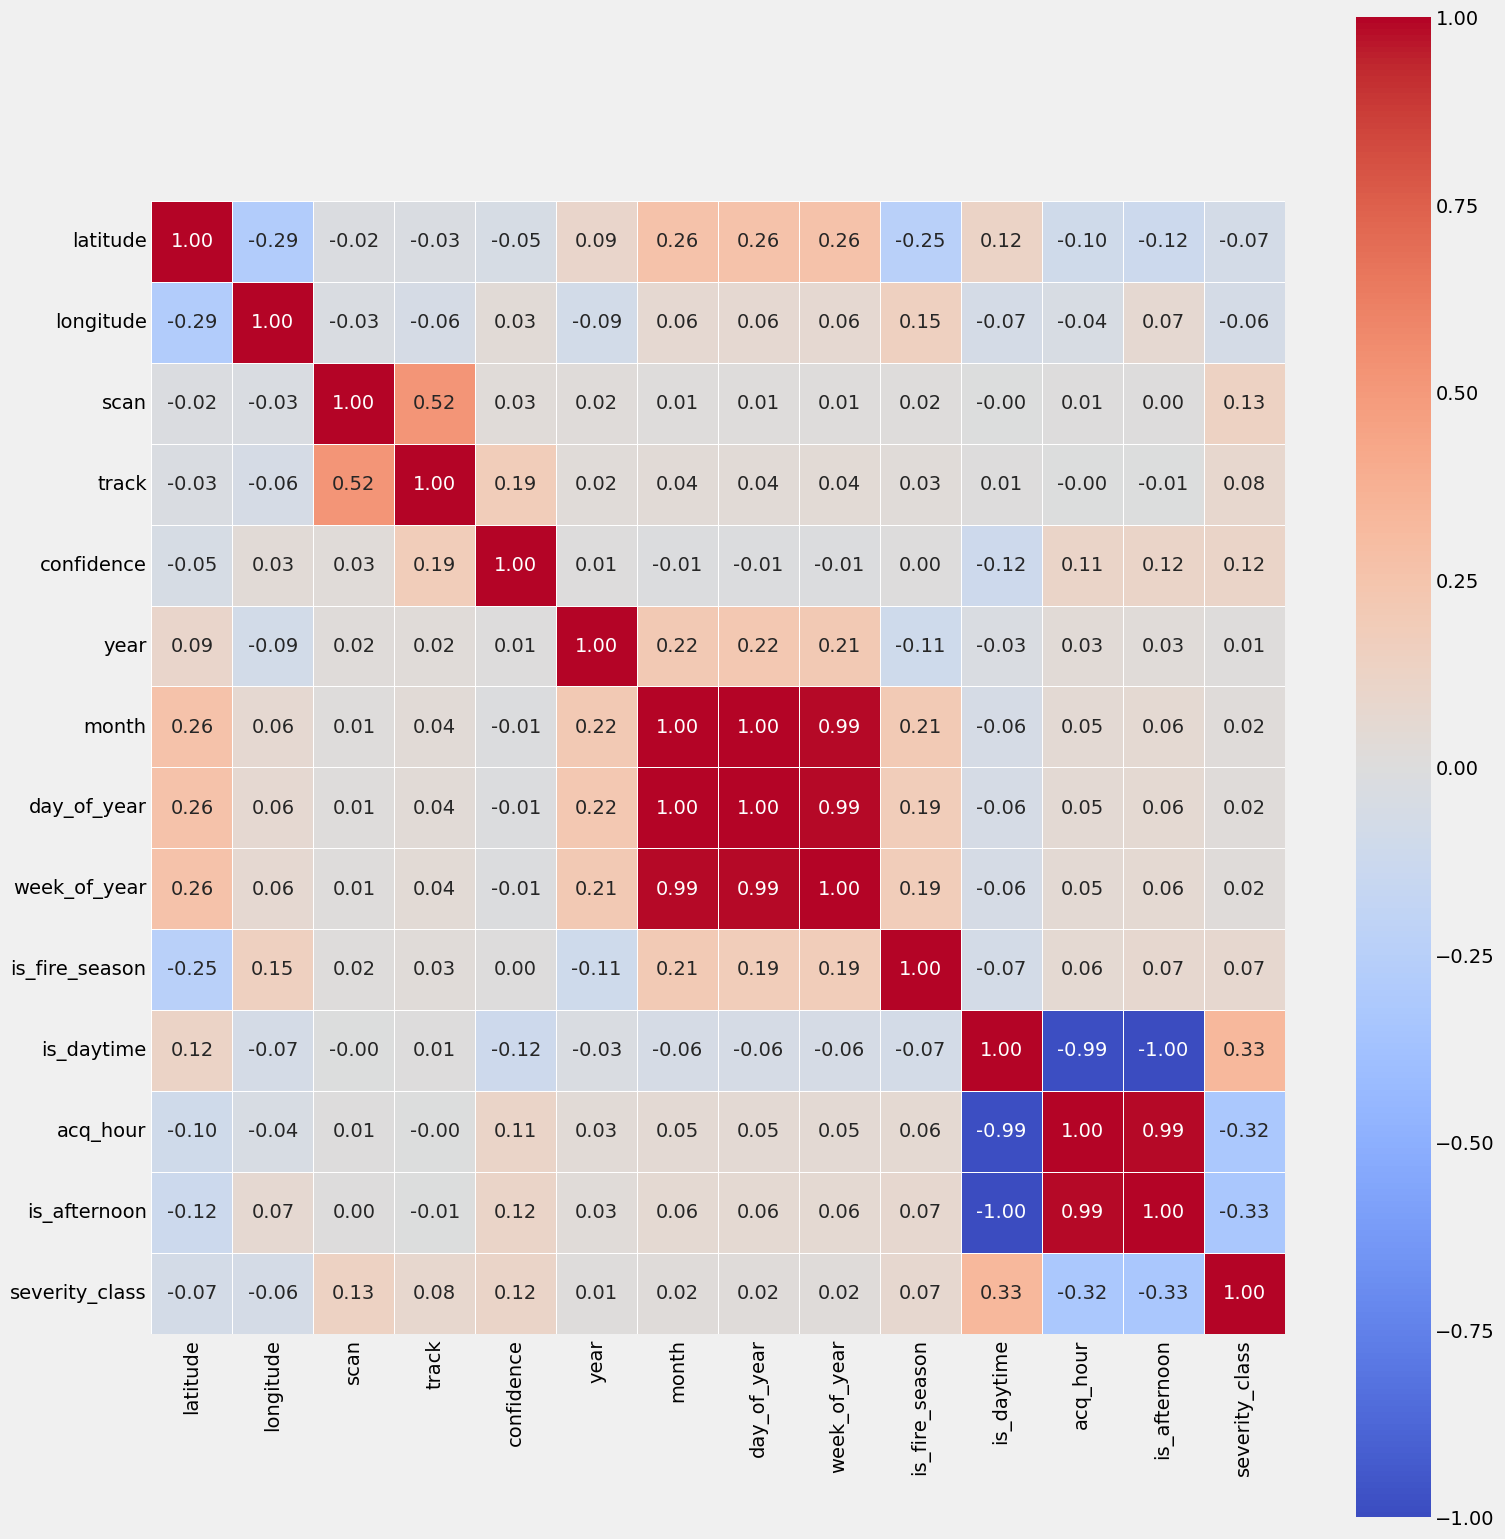

In [14]:
# Correlation heatmap for numerical features
plt.figure(figsize=(16, 16))
correlation_matrix = df[num_col].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5,fmt='.2f')
plt.tight_layout()
plt.show()